# This File is for image processing, extracting feature points and data formatting 

### Dan Luo. CAADRIA 2020 Pre-Workshop
##### http://papers.cumincad.org/data/works/att/caadria2018_083.pdf

### Import Library

In [14]:
import cv2
import os
import numpy as np
from skimage import morphology,data,color
import matplotlib.pyplot as plt
from image_utils import *
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

### STEP 0 - Preparation: Image sequence has already been extracted from video, cropped, and saved to the folder "all_imgs"

### STEP 1 - Taking a image from folder "all_image" as an example

In [15]:
# Export the results into the folder './stepdir/'
stepdir = './stepdir/'
if not os.path.exists(stepdir):
    os.mkdir(stepdir)

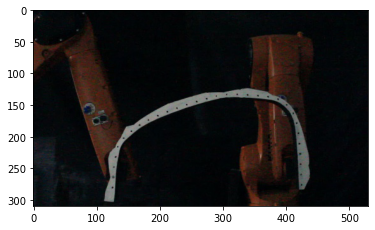

In [16]:
frame1=cv2.imread('all_imgs/MVI_3010.MOV0.jpeg')
cv2.imwrite(stepdir+"frame1.jpeg", frame1)
plt.imshow(frame1[:,:,::-1]) 
# Because when plt.imshow, it requires RGB read in different order comparing to cv2, 
# thus need to swap the order of RGB for display 


### STEP 2: Change the RGB image to grayscale image

(310, 530)


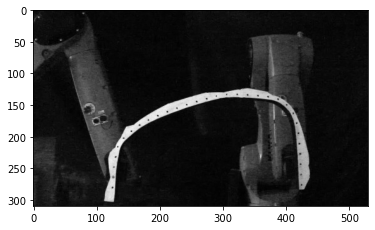

In [17]:
frame2 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
print(frame2.shape)
cv2.imwrite(stepdir+"frame2.jpeg", frame2)
plt.imshow(frame2,'gray')

### STEP 3: Image Binarylization, for feature extraction.

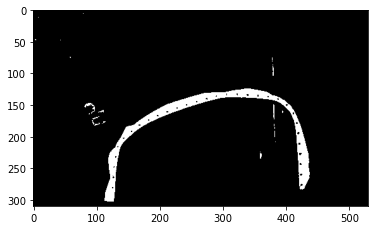

In [18]:
ret, frame3 = cv2.threshold(frame2, 80, 255, cv2.THRESH_BINARY)
cv2.imwrite(stepdir+"frame3.jpeg", frame3)
plt.imshow(frame3,'gray')

### STEP 4: Remove white the noise and keep the main profile.

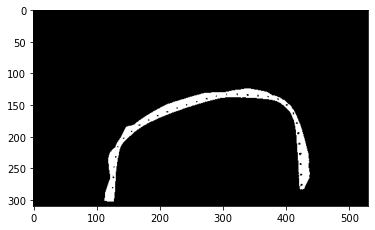

In [19]:
frame4=denoising(frame3)
cv2.imwrite(stepdir+"frame4.jpeg", frame4)
plt.imshow(frame4,'gray')

### STEP 5: Remove the black dots from interior

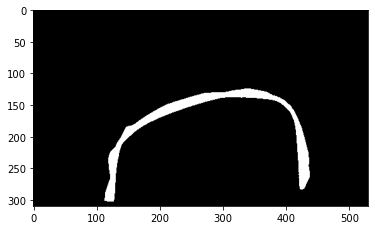

In [20]:
frame5=inToOut(frame4)
cv2.imwrite(stepdir+"frame5.jpeg", frame5)
plt.imshow(frame5,'gray')

### STEP 6: Smooth edges (if not smoothed, the extracted lower boundaried could be short and incomplete)

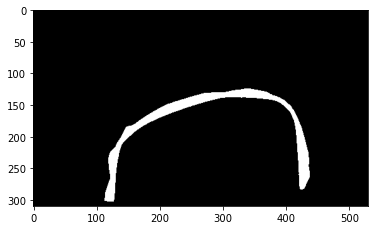

In [21]:
frame6 = smooth(frame5)
cv2.imwrite(stepdir+"frame6.jpeg", frame6)
plt.imshow(frame6,'gray')

### STEP 7: Extracting lower edge.

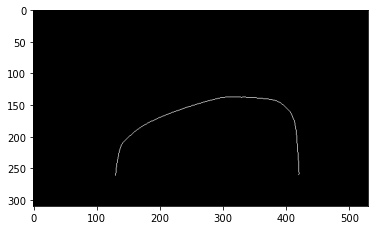

In [22]:
bottom_curve,bottom = findBottom(frame6,260,360)
cv2.imwrite(stepdir+"step7_bottom.jpeg", bottom)
plt.imshow(bottom,'gray')

### STEP 8: Extracting middle line

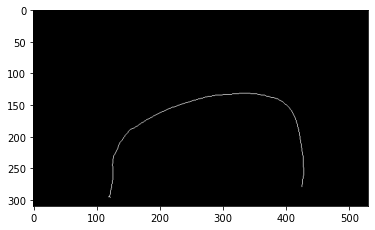

In [23]:
raw_skeleton = rawSkeloton(frame6)
cv2.imwrite(stepdir+"step8_raw_skeleton.jpeg", raw_skeleton)
plt.imshow(raw_skeleton,'gray')

### STEP 9: Mid-line optimization 
    the mid_line could be branching, choose the longest branch

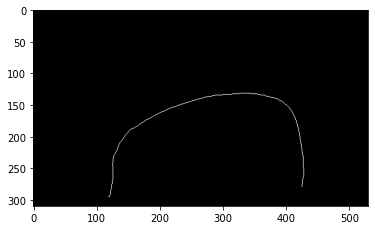

In [24]:
mid_curve, mid = optimizeSkeloton(raw_skeleton)
cv2.imwrite(stepdir+"step9_mid.jpeg", mid)
plt.imshow(mid,'gray')

### STEP 10: Extracting training data points
    Sample at bottom_curve, find the normal, intersect normal with mid_curve, the length of normal segmented between mid and the bottom is half of the overall thickness. 

In [25]:
midSelect, bottomSelect,vectorSelect = generateData(mid_curve, bottom_curve, 5,240)

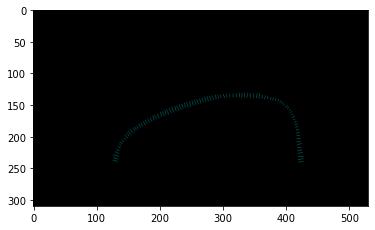

In [34]:
frame_s = np.zeros((len(frame6), len(frame6[0]), 3),dtype=np.uint8)
for n in range(len(bottomSelect)):
    bi,bj = bottomSelect[n]
    mi,mj = midSelect[n]
    
    cv2.line(frame_s,(bj,bi),(int(mj),int(mi)),(0,100,100),1)
cv2.imwrite(stepdir+"stepframe_s.jpeg", frame_s)
plt.imshow(frame_s)

### Data validation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

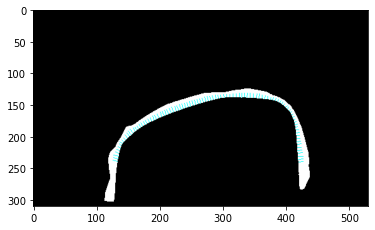

In [39]:
frame_v = np.concatenate((frame6[:,:,None],frame6[:,:,None],frame6[:,:,None]),axis=2)
for n in range(len(bottomSelect)):
    bi,bj = bottomSelect[n]
    mi,mj = midSelect[n]
    cv2.line(frame_v,(bj,bi),(int(mj),int(mi)),(150,150,0),1)
plt.imshow(frame_v[:,:,::-1])
cv2.imwrite(stepdir+"stepframe_v.jpeg", frame_v)
cv2.imwrite("frame_v.jpeg", frame_v)

#### =======================================================

## SAVING the DATA. 
## Run this block independently and it will generate all training dataset.

In [ ]:

all_datas=[]
input_dir='all_imgs/'
for i,input_img in enumerate(os.listdir(input_dir)):
    if '.jpeg' not in input_img:
        continue
    if i%100==0:
        print('finish {} of {}'.format(i,len(os.listdir(input_dir))))
    try:
        frame1 = cv2.imread(input_dir+input_img)
        frame2 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        _, frame3 = cv2.threshold(frame2, 80, 255, cv2.THRESH_BINARY)
        frame4=denoising(frame3)
        frame5=inToOut(frame4)
        frame6 = smooth(frame5)
        bottom_curve,bottom = findBottom(frame6,240,360)
        raw_skeleton = rawSkeloton(frame6)
        mid_curve, mid = optimizeSkeloton(raw_skeleton)
        midSelect, bottomSelect,vectorSelect = generateData(mid_curve, bottom_curve, 5,240)
        midSelect = np.squeeze(np.array(midSelect))
        bottomSelect = np.squeeze(np.array(bottomSelect))
        vectorSelect = np.squeeze(np.array(vectorSelect))
        thickness = np.linalg.norm(midSelect-bottomSelect,axis=1)
        all_datas.append([midSelect,bottomSelect,vectorSelect,thickness])
    except:
        print(input_img)

In [ ]:
np.save('all_datas01.npy',all_datas)